In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [23]:
dataset = "CelebA"
ratios = ["100-0", "75-25", "50-50", "25-75", "0-100"]
n_folds = 10
n_runs = 1

exp_dir = Path(f"../../results/ratios_single/trained_models/{dataset}")
out_dir = Path(f"../../results/ratios_single/plots/")
out_dir.mkdir(parents=True, exist_ok=True)

In [24]:
df_all = pd.DataFrame()
for ratio in ratios:
    for fold in range(1, n_folds+1):
        for run in range(1, n_runs+1):
            df = pd.read_csv(exp_dir / f"{ratio}/fold_{fold}/run_{run}/predictions/predictions.csv")
            df["fold"] = fold
            df["run"] = run
            df["ratio"] = ratio
            df["y_correct"] = np.abs(df["y"] == df["y_pred"])
            df_all = pd.concat([df_all, df], axis=0)

In [25]:
df_grouped = df_all.groupby(["ratio", "fold", "run", "a"])["y_correct"].mean().reset_index()
df_grouped = df_grouped.rename(columns={"y_correct": "acc"})
df_grouped["a"] = df_grouped["a"].map({0: "Male", 1: "Female"}) 

In [26]:
df_ratios = df_grouped.groupby(["ratio", "a"])["acc"].agg(["mean", "std"]).reset_index()
df_ratios_m = df_ratios[df_ratios["a"] == "Male"].reset_index().iloc[[1, 4, 3, 2, 0], :]
df_ratios_f = df_ratios[df_ratios["a"] == "Female"].reset_index().iloc[[1, 4, 3, 2, 0], :]

print(df_ratios_m.round(3))
print(df_ratios_f.round(3))

   index  ratio     a   mean    std
1      3  100-0  Male  0.831  0.008
4      9  75-25  Male  0.828  0.010
3      7  50-50  Male  0.815  0.010
2      5  25-75  Male  0.810  0.015
0      1  0-100  Male  0.697  0.021
   index  ratio       a   mean    std
1      2  100-0  Female  0.681  0.015
4      8  75-25  Female  0.819  0.014
3      6  50-50  Female  0.834  0.011
2      4  25-75  Female  0.838  0.007
0      0  0-100  Female  0.843  0.007


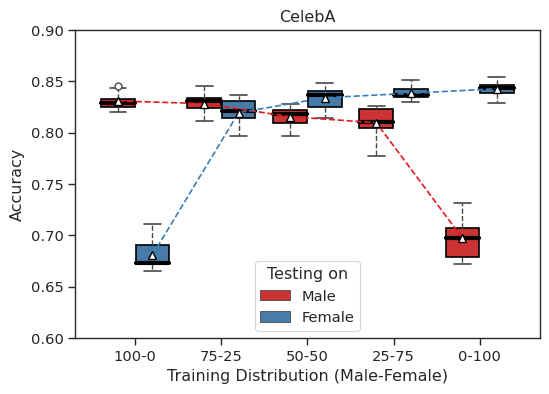

In [27]:
sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.2)
palette_name = "Set1" 

flierprops = dict(marker="o", markerfacecolor="white")
meanprops = dict(markerfacecolor="blue", markeredgecolor="blue")
medianprops = dict(linewidth=3, color="black")
boxprops = dict(edgecolor="black")
whiskerprops = dict(linestyle="--", linewidth=1)
plot_params = {"showmeans": False, "flierprops": flierprops, "whiskerprops": whiskerprops, "boxprops": boxprops, "meanprops": meanprops, "medianprops": medianprops, "palette": palette_name}

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_grouped, x="ratio", y="acc", hue="a", order=ratios, zorder=1, **plot_params)

plt.gca().yaxis.set_major_formatter('{:.2f}'.format)
plt.ylim(0.6, 0.9)

plt.xlabel("Training Distribution (Male-Female)")
plt.ylabel("Accuracy")
plt.title(f"{dataset}")
plt.legend(title="Testing on")#, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.legend(title="Testing on")
if dataset == "UTKFace":
    plt.ylim(5, 10)

means = df_grouped.groupby(["a", "ratio"])["acc"].mean().reset_index()
means_f = means.iloc[[1, 4, 3, 2, 0], :]
means_m = means.iloc[[6, 9, 8, 7, 5], :]

hue_colors = sns.color_palette(palette_name, n_colors=len(df_grouped['a'].unique()))
for i, hue_value in enumerate([means_m, means_f]):
    if i == 0: # Male
        plt.plot(np.arange(5)-0.2, means_m["acc"], color=hue_colors[i % len(hue_colors)], marker="^", linestyle='--', linewidth=1.2, markersize=6, markeredgecolor="black", markerfacecolor="white")
    else:
        plt.plot(np.arange(5)+0.2, means_f["acc"], color=hue_colors[i % len(hue_colors)], marker="^", linestyle='--', linewidth=1.2, markersize=6, markeredgecolor="black", markerfacecolor="white")


# sns.despine()
plt.savefig(out_dir / f"acc_ratios_{dataset}.png", dpi=300, bbox_inches="tight")

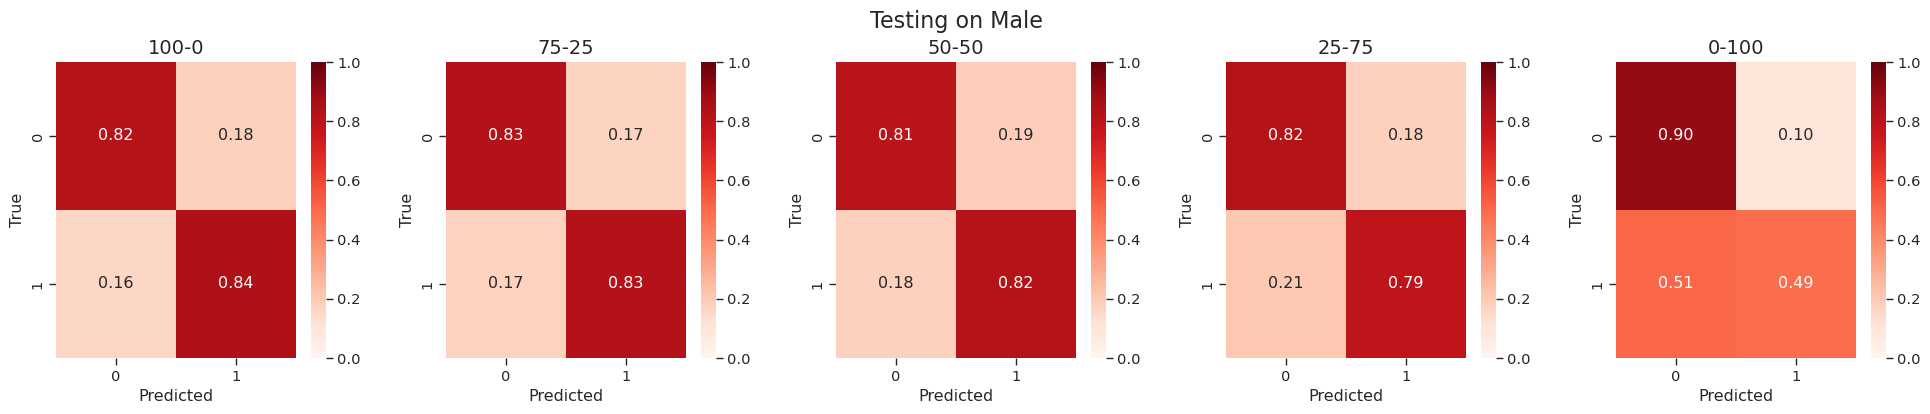

In [28]:
gender = "Male"
idx = 0 if gender == "Male" else 1

df_ = df_all[df_all["a"] == idx]

sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.2)

plt.subplots(1, len(ratios), figsize=(24, 4))
plt.suptitle(f"Testing on {gender}", fontsize=16)
plt.subplots_adjust(top=0.85, wspace=0.3)

for ratio in ratios:
    y_true = df_[df_["ratio"] == ratio]["y"]
    y_pred = df_[df_["ratio"] == ratio]["y_pred"]
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    plt.subplot(1, len(ratios), ratios.index(ratio)+1)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", vmin=0, vmax=1)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{ratio}", fontsize=14)

plt.savefig(out_dir / f"cmatrix_{gender.lower()}_ratios_{dataset}.png", dpi=300, bbox_inches="tight")

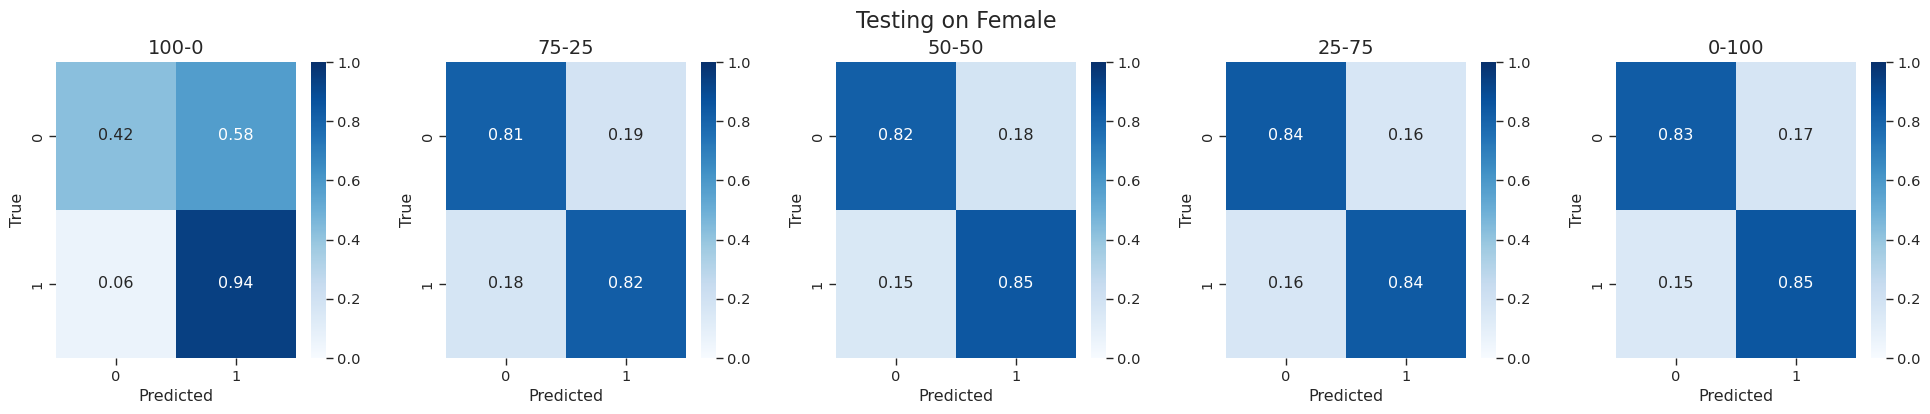

In [29]:
gender = "Female"
idx = 0 if gender == "Male" else 1

df_ = df_all[df_all["a"] == idx]

sns.set_theme(style="ticks")
sns.set_context("paper", font_scale=1.2)

plt.subplots(1, len(ratios), figsize=(24, 4))
plt.suptitle(f"Testing on {gender}", fontsize=16)
plt.subplots_adjust(top=0.85, wspace=0.3)

for ratio in ratios:
    y_true = df_[df_["ratio"] == ratio]["y"]
    y_pred = df_[df_["ratio"] == ratio]["y_pred"]
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    plt.subplot(1, len(ratios), ratios.index(ratio)+1)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{ratio}", fontsize=14)

plt.savefig(out_dir / f"cmatrix_{gender.lower()}_ratios_{dataset}.png", dpi=300, bbox_inches="tight")

In [30]:
equal_opportunity_results = []

for ratio in ratios:
    for fold in range(1, n_folds+1):
        for run in range(1, n_runs+1):
            df = pd.read_csv(exp_dir / f"{ratio}/fold_{fold}/run_{run}/predictions/predictions.csv")
            df["fold"] = fold
            df["run"] = run
            df["ratio"] = ratio
            df["y_correct"] = np.abs(df["y"] == df["y_pred"])

            # Group by sensitive attribute (e.g., gender)
            grouped_data = df.groupby("a")

            # Calculate True Positive Rate for each group
            for group_name, group_df in grouped_data:
                true_positives = group_df[(group_df["y_correct"] == 1) & (group_df["y"] == 1)].shape[0]
                total_positives = group_df[group_df["y"] == 1].shape[0]

                # Avoid division by zero
                tpr = true_positives / total_positives if total_positives > 0 else 0

                # Append results to the list
                equal_opportunity_results.append({
                    "ratio": ratio,
                    "fold": fold,
                    "run": run,
                    "a": group_name,
                    "equal_opportunity": tpr
                })

# Create a DataFrame from the results
equal_opportunity_df = pd.DataFrame(equal_opportunity_results)


In [31]:
eod_results = []

for ratio in ratios:
    for fold in range(1, n_folds+1):
        for run in range(1, n_runs+1):
            df = pd.read_csv(exp_dir / f"{ratio}/fold_{fold}/run_{run}/predictions/predictions.csv")
            df["fold"] = fold
            df["run"] = run
            df["ratio"] = ratio
            df["y_correct"] = np.abs(df["y"] == df["y_pred"])

            grouped_data = df.groupby("a")

            tpr_by_group = {}
            for group_name, group_df in grouped_data:
                true_positives = group_df[(group_df["y_correct"] == True) & (group_df["y"] == 1)].shape[0]
                total_positives = group_df[group_df["y"] == 1].shape[0]

                tpr = true_positives / total_positives if total_positives > 0 else 0
                tpr_by_group[group_name] = tpr

            eod = abs(tpr_by_group[0] - tpr_by_group[1])

            eod_results.append({
                "ratio": ratio,
                "fold": fold,
                "run": run,
                "eod": eod
            })

eod_df = pd.DataFrame(eod_results)

In [33]:
eod_df.groupby("ratio")["eod"].agg(["mean", "std"]).reset_index().iloc[[1, 4, 3, 2, 0], :].round(3)

,ratio,mean,std
1,100-0,0.096,0.043
4,75-25,0.030,0.021
3,50-50,0.034,0.025
2,25-75,0.052,0.043
0,0-100,0.363,0.071
